Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading the dataset files

In [2]:
book_ratings = pd.read_csv('/content/drive/My Drive/BX-CSV-Dump(1)/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
book_ratings.columns = ['userID', 'ISBN', 'bookRating']
books = pd.read_csv('/content/drive/My Drive/BX-CSV-Dump(1)/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('/content/drive/My Drive/BX-CSV-Dump(1)/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:27

In [3]:
print(book_ratings.shape)
book_ratings.head()

(1149780, 3)


,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


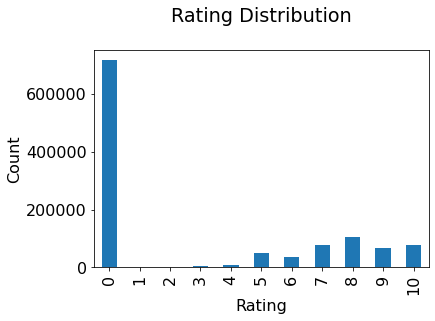

In [4]:
plt.rc("font", size=16)
book_ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
#plt.savefig('system1.png', bbox_inches='tight')
plt.show()

In [5]:
print(books.shape)
books.head()

(271360, 8)


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
#Feature selection

books=books[['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher']] 

In [7]:
print(users.shape)
users.head()

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Generating book recommendations based on the ratings count.

In [8]:
#Based on the ratings count, the most rated book will be recommended and so on.

rating_count = pd.DataFrame(book_ratings.groupby('ISBN')['bookRating'].count())
rating_count.sort_values('bookRating', ascending=False).head()

,bookRating
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723


In [9]:
most_rated_books = pd.DataFrame(['0971880107', '0316666343', '0385504209', '0060928336', '0312195516'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_details = pd.merge(most_rated_books, books, on='ISBN')
most_rated_books_details

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
2,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
4,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA


**Generating book recommendations based on correlations(Pearsons'R Correlation).**

The Pearsons’R correlation coefficient is used to measure the linear correlation between two variables, in this case, the ratings for two books.
First, we need to find out the average rating, and the number of ratings each book received.

In [10]:
average_rating = pd.DataFrame(book_ratings.groupby('ISBN')['bookRating'].mean())
average_rating['ratingCount'] = pd.DataFrame(book_ratings.groupby('ISBN')['bookRating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,bookRating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


As it can be observed that the book with highest number of ratings is least rated. Hence, this can create ambiguity and errors. Due to this reason, we need to have a better system.

To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [30]:
#Excluding books with less than 100 ratings
counts = book_ratings['bookRating'].value_counts()
book_ratings = book_ratings[book_ratings['bookRating'].isin(counts[counts >= 100].index)]

#Excluding users with less than 200 ratings
counts1 = book_ratings['userID'].value_counts()
book_ratings = book_ratings[book_ratings['userID'].isin(counts1[counts1 >= 200].index)]


We convert the ratings table to a 2D ratings matrix. The matrix will be sparse because not every user rated every book.



In [31]:
book_ratings_pivot = book_ratings.pivot(index='userID', columns='ISBN').bookRating
userID = book_ratings_pivot.index
ISBN = book_ratings_pivot.columns
print(book_ratings_pivot.shape)
book_ratings_pivot.head()

(905, 207699)


ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,9061002273,*0515128325,+0451197399,0 00 612183 7,0 00 614494 2,0 7336 1053 6,0 907 062 008,0*708880258,0.330241664,00000000,000000000,0000000000,00000000000,000000000000,0000000000000,0000000029841,0000000030670,0000000033220,0000000051,0000001042283,0000001481,0000018030,0000722105029,0000913154,0001010565,0001046438,000104687X,0001047213,0001047639,0001047663,...,O425155404,O42516313X,O439060737,O439161673,O446611638,O451203771,O499139921,O590418262,O590477412,O59052528X,O67174142X,O774037474,O77O428452,O786001690,O805063196,O856856428,O861366301,O880015152,O889950962,O9088446X,PS3569E84K5,Q380708353,Q912838027,SBN67001026X,T110105305048,T110105705048,TBR0385495641,THEALLTRUETRA,THECATASTROPH,THEFLYINGACE,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,"\0432534220\""""","\2842053052\""""",b00005wz75,cn108465,cn113107,Ô½crosoft
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
book1_ratings = book_ratings_pivot['0316666343']
similar_to_book1 = book_ratings_pivot.corrwith(book1_ratings)
corr_book1 = pd.DataFrame(similar_to_book1, columns=['pearsonR'])
corr_book1.dropna(inplace=True)
corr_summary = corr_book1.join(average_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>=200].sort_values('pearsonR', ascending=False).head(10)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,pearsonR,ratingCount
ISBN,,
0316666343,1.000000,1295
0440211263,0.537130,229
0312291639,0.471872,354
0316601950,0.434248,568
0446610038,0.429712,391
0446672211,0.421478,585
0440236703,0.372455,210
0446601241,0.372135,229
0385265700,0.351635,319


Now, as ISBN of books are obtained, we will find out the book details in the following code cell.

In [35]:
books_corr_to_book1 = pd.DataFrame(['0316666343',
'0440211263', 
'0312291639',
'0316601950',
'0446610038', 	
'0446672211'],index=np.arange(6), columns=['ISBN'])
corr_books = pd.merge(books_corr_to_book1, books, on='ISBN')
corr_books

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0440211263,Circle of Friends,Maeve Binchy,1991,Dell
2,0312291639,The Nanny Diaries: A Novel,Emma McLaughlin,2003,St. Martin's Griffin
3,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999,Back Bay Books
4,0446610038,1st to Die: A Novel,James Patterson,2002,Warner Vision
5,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
